# Oxford5k VLAD anf Fisher Vector Retrieval Demo

This notebook demonstrates how to:
1. Load the Oxford Flower dataset.
2. Extract deep convolutional features (last conv layer) from a pretrained model.
3. Train a VLAD model on these deep features.
4. Perform image retrieval queries.
5. Show the effect of PCA (reducing features by half before VLAD) on retrieval performance.
6. An analogous procedure is made for Fisher Vectors




## 1. Imports and Setup

In [3]:
from itertools import islice

from torchvision.models import vgg16, VGG16_Weights

# Our library imports
from src.features import DeepConvFeature
from src.encoders.vlad import VLADEncoder
from src.encoders.fisher_vector import FisherVectorEncoder
from src.datasets import OxfordFlowerDataset  # We'll create this in a moment
from src.config import DEVICE, ROOT
from src.utils import *
from scripts.train import train_k_means, train_pca, train_gmm
from scripts.evaluate import retrieve_top_k_similar

print("Device in use:", DEVICE)

Device used: cuda


C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Device in use: cuda


### Hyperparameters

**Note**: training k-means models takes quite a bit of time. In this notebook, a single `n_clusters = 256` will be used. Add more values to `NUM_CLUSTERS` to experiment with different cluster sizes.

In [1]:
NUM_CLUSTERS = 256
IMAGE_SIZE = (224, 224)
DIM_REDUCTION_FACTOR = 2

## 2. Declare the Oxford Flower Dataset

The VGG16 model requires input images as tensors and of size 224x224. To ensure compatibility, the transformations below are applied to the dataset.

In [4]:
train_dataset = OxfordFlowerDataset(purpose='train')
val_dataset = OxfordFlowerDataset(purpose='validation')
print("Number of images in the dataset:", len(train_dataset))

Number of images in the dataset: 6149


### Plot some images

Image size: (500, 591, 3)


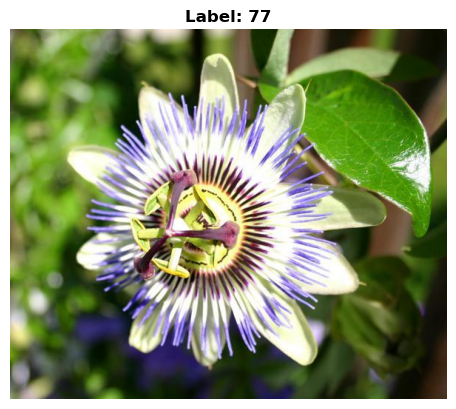

Image size: (500, 625, 3)


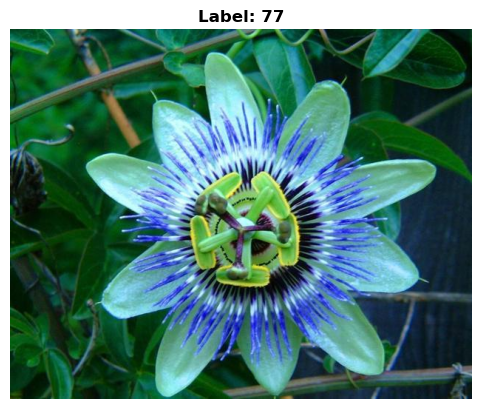

Image size: (667, 500, 3)


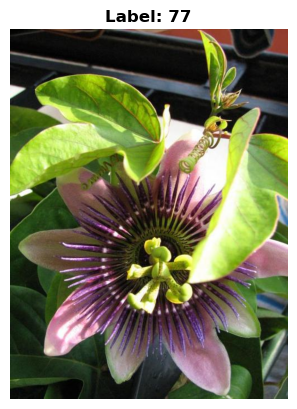

Image size: (500, 667, 3)


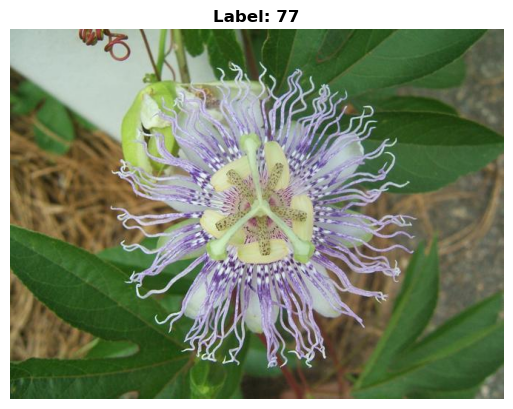

Image size: (500, 508, 3)


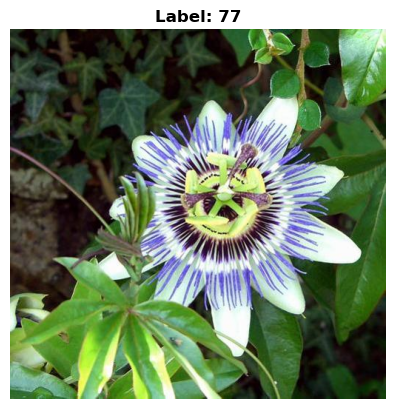

In [5]:
for i in range(5):
    img, label, _ = train_dataset[i]
    print("Image size:", img.shape)
    plot_image(img, title = f"Label: {label}")

### 3. Extract deep convolutional features

We use `DeepConvFeatureExtractor` from our code. For demonstration, we'll pick `vgg16` and the last conv layer.


In [6]:
extractor = DeepConvFeature(
    model=vgg16(weights=VGG16_Weights.DEFAULT),
    layer_index=-1,  # Last conv layer
    spatial_encoding=True,
    device=DEVICE
)

2025-01-10 17:17:53,997 - Feature_Extractor - INFO - Selected layer: features.28, Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Extract features

**WARNING**: This loads all images and feature maps into memory. Make sure your computer can handle the data.


In [7]:
NUM_IMGS = None

In [8]:
labels, paths, features = [], [], []
for img, lbl, path in islice(train_dataset, NUM_IMGS if NUM_IMGS is not None else len(train_dataset)):
    labels.append(lbl)
    paths.append(path)
    features.append(extractor(img))

labels = np.array(labels)
features = np.vstack(features)

## **4. Training VLAD Model**
We'll train the K-Means model, which is essential for the VLAD Encoding model. This might take a while.

In [9]:
kmeans_model_no_pca = train_k_means(n_clusters=NUM_CLUSTERS, features=features)
save_model(kmeans_model_no_pca, f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [9]:
kmeans_model_no_pca = load_model(f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

### Declare the VLAD encoder (no PCA)

In [10]:
vlad_encoder_no_pca = VLADEncoder(
    feature_extractor=extractor,
    kmeans_model=kmeans_model_no_pca,
    power_norm_weight=1,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
)

vlad_data = vlad_encoder_no_pca.generate_encoding_map(paths)

Similar to above, but here, the dimension of each feature vector is reduced `by half` using `PCA`.

In [10]:
pca_model_vlad = train_pca(reduction_factor=DIM_REDUCTION_FACTOR, features=features)
features_pca_vlad = pca_model_vlad.transform(features)
save_model(pca_model_vlad, f"{ROOT}/models/pickle_model_files/pca_vlad_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{pca_model_vlad._n_features_out}.pkl")

kmeans_model_pca = train_k_means(n_clusters=NUM_CLUSTERS, features=features_pca_vlad)
save_model(kmeans_model_pca, f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [11]:
dim_pca_vlad = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_vlad = load_model(f"{ROOT}/models/pickle_model_files/pca_vlad_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_vlad}.pkl")
kmeans_model_pca = load_model(f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

### Declare the VLAD encoder (with PCA)

In [12]:
vlad_encoder_with_pca = VLADEncoder(
    feature_extractor=extractor,
    kmeans_model=kmeans_model_pca,
    power_norm_weight=1,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
    pca=pca_model_vlad
)

vlad_data_pca = vlad_encoder_with_pca.generate_encoding_map(paths)

## **5. Compare some images**

We will now use the trained VLAD encoders to compute similarity between some images.

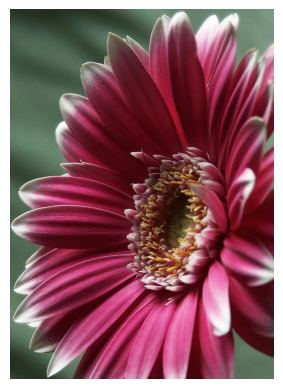

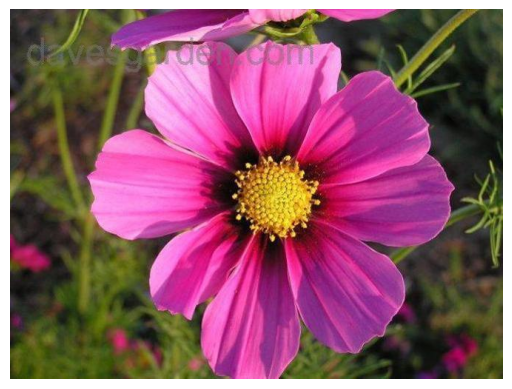

In [13]:
image_1, label_1, path_1 = train_dataset[2005]
image_2, label_2, path_2 =  val_dataset[401]
plot_image(image_1)
plot_image(image_2)

Now, we compare the two images. `cosine similarity` is used in this case.

In [14]:
sim_with_pca = vlad_encoder_with_pca.similarity_score(image_1, image_2)
print("Similarity Score, with PCA: ", sim_with_pca)
sim_without_pca = vlad_encoder_no_pca.similarity_score(image_1, image_2)
print("Similarity Score, without PCA: ", sim_without_pca)

Similarity Score, with PCA:  0.0487862154841423
Similarity Score, without PCA:  0.040725577622652054


## **6. Fetch the most similar image in the dataset, given a query image**

Now, we will select an image in the validation dataset, on which the model is not yet trained:

In [15]:
query_image, query_label, query_path =  val_dataset[103]

Retrieve top-k most similar images using the datasets computed. We will see how it works, with and without PCA.

In [16]:
top_k_vlad_pca = retrieve_top_k_similar(query_image, vlad_data_pca, vlad_encoder_with_pca)
for path, score in top_k_vlad_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

tok_k_vlad_no_pca = retrieve_top_k_similar(query_image, vlad_data, vlad_encoder_no_pca)
for path, score in tok_k_vlad_no_pca:
    print(f"\nPath: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

Path: image_06366.jpg, Cosine similarity: 0.1177
Path: image_06347.jpg, Cosine similarity: 0.1078
Path: image_06383.jpg, Cosine similarity: 0.0934
Path: image_00970.jpg, Cosine similarity: 0.0852
Path: image_00769.jpg, Cosine similarity: 0.0852

Path: image_06347.jpg, Cosine similarity: 0.1250

Path: image_06366.jpg, Cosine similarity: 0.0982

Path: image_06383.jpg, Cosine similarity: 0.0927

Path: image_06369.jpg, Cosine similarity: 0.0873

Path: image_00970.jpg, Cosine similarity: 0.0860


### Let's plot both images next to each other.


a) Using Model trained on data with PCA

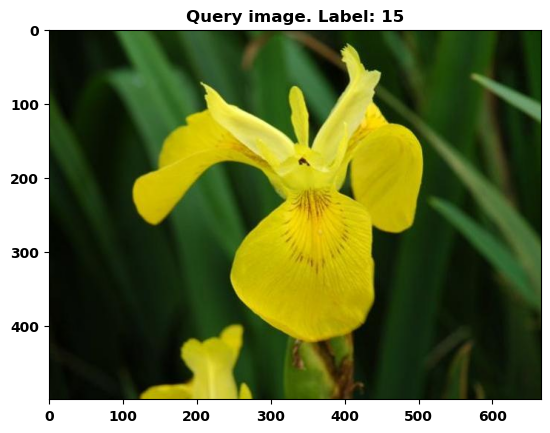

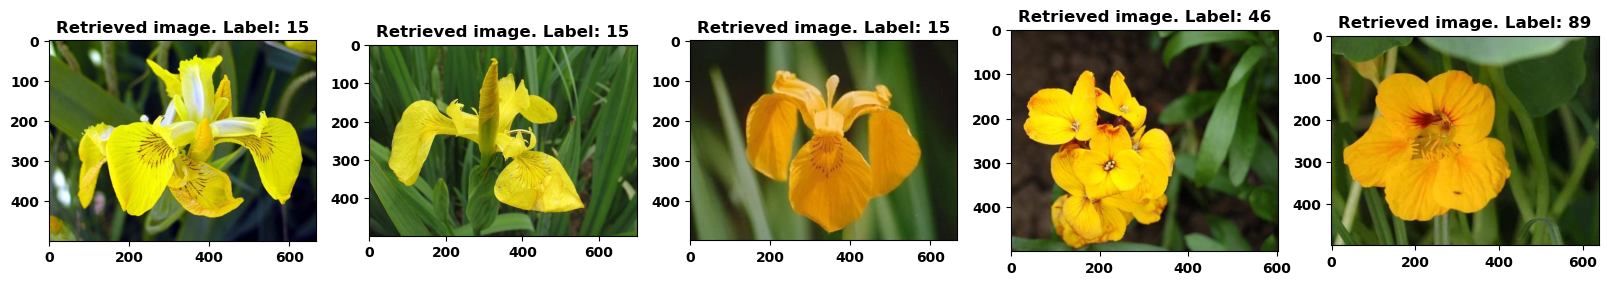

In [24]:
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(len(top_k_vlad_pca)):
    path, _ = top_k_vlad_pca[i]
    label = train_dataset.labels[train_dataset.image_paths.index(path)]
    plt.subplot(1, len(top_k_vlad_pca), i + 1)
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Retrieved image. Label: {label}")

plt.show()

b) Using model trained on full data

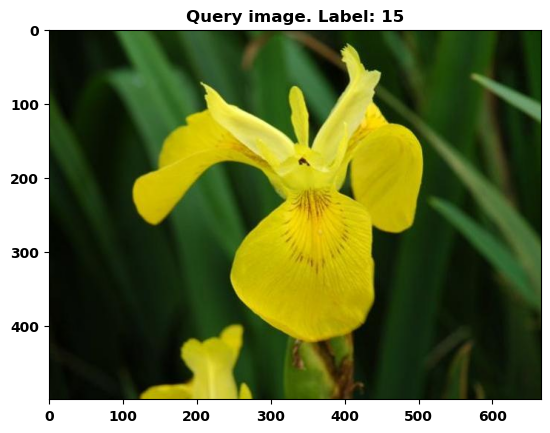

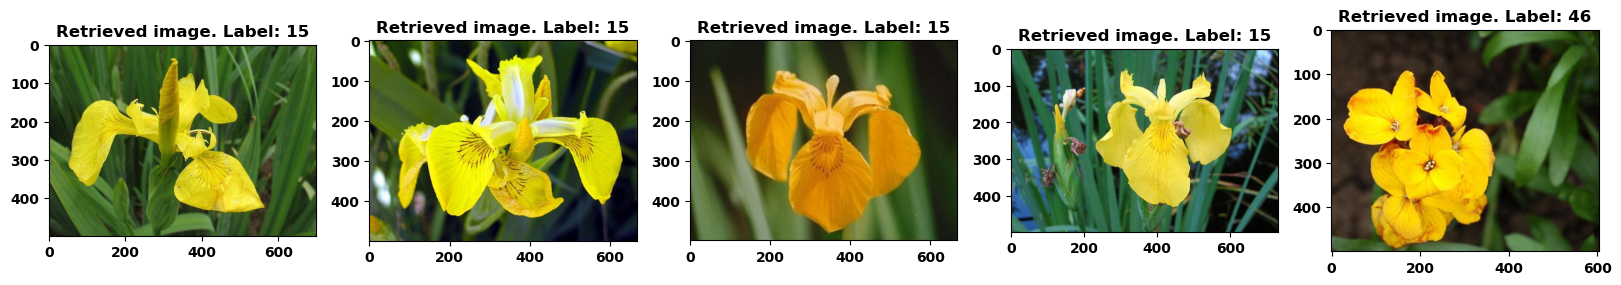

In [26]:
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(len(tok_k_vlad_no_pca)):
    path, _ = tok_k_vlad_no_pca[i]
    label = train_dataset.labels[train_dataset.image_paths.index(path)]
    plt.subplot(1, len(tok_k_vlad_no_pca), i + 1)
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Retrieved image. Label: {label}")

plt.show()

## **7. Similar to above, we will do the exact things for the Fisher Vector**

The implementation for both VLAD and Fisher Vectors are identical. After all, VLAD is simply a simplified case of Fisher Vector.

### Fit GMM model

In [11]:
gmm_model_no_pca = train_gmm(n_components=NUM_CLUSTERS, features=features)
save_model(gmm_model_no_pca, f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [27]:
gmm_model_no_pca = load_model(f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

### Instantiate Fisher Vector Encoder without PCA

In [28]:
fisher_encoder_no_pca = FisherVectorEncoder(
    feature_extractor=extractor,
    gmm_model=gmm_model_no_pca,
    power_norm_weight=0.5,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
)

fisher_data = fisher_encoder_no_pca.generate_encoding_map(paths)

### Using PCA to reduce features by half

In [ ]:
pca_model_fisher = train_pca(reduction_factor=DIM_REDUCTION_FACTOR, features=features)
features_pca_fisher = pca_model_fisher.transform(features)
save_model(pca_model_fisher, f"{ROOT}/models/pickle_model_files/pca_fisher_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{pca_model_fisher._n_features_out}.pkl")

gmm_model_pca = train_gmm(n_components=NUM_CLUSTERS, features=features_pca_fisher)
save_model(gmm_model_pca, f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [29]:
dim_pca_fisher = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_fisher = load_model(f"{ROOT}/models/pickle_model_files/pca_fisher_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_fisher}.pkl")
gmm_model_pca = load_model(f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

### Instantiate Fisher Vector Encoder with PCA

In [30]:
fisher_encoder_with_pca = FisherVectorEncoder(
    feature_extractor=extractor,
    gmm_model=gmm_model_pca,
    power_norm_weight=0.5,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
    pca=pca_model_fisher,
)

fisher_data_pca = fisher_encoder_with_pca.generate_encoding_map(paths)

### Compute similarity of two images

In [31]:
image_similarity_with_pca = fisher_encoder_with_pca.similarity_score(image_1, image_2)
image_similarity_without_pca = fisher_encoder_no_pca.similarity_score(image_1, image_2)
print("Fisher Similarity Score, with PCA: ", image_similarity_with_pca)
print("Fisher Similarity Score, without PCA: ", image_similarity_without_pca)

Fisher Similarity Score, with PCA:  0.02311501172827345
Fisher Similarity Score, without PCA:  0.2269404237932219


### Retrieve top-k most similar images

In [32]:
top_k_fisher_pca = retrieve_top_k_similar(query_image, fisher_data_pca, fisher_encoder_with_pca)
print("Evaluation of fisher vector with PCA:")
for path, score in top_k_fisher_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

top_k_fisher_no_pca = retrieve_top_k_similar(query_image, fisher_data, fisher_encoder_no_pca)
print("\nEvaluation of Fisher Vector without PCA:")
for path, score in top_k_fisher_no_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

Evaluation of fisher vector with PCA:
Path: image_06383.jpg, Cosine similarity: 0.0901
Path: image_06366.jpg, Cosine similarity: 0.0813
Path: image_06351.jpg, Cosine similarity: 0.0732
Path: image_06347.jpg, Cosine similarity: 0.0679
Path: image_00970.jpg, Cosine similarity: 0.0645

Evaluation of Fisher Vector without PCA:
Path: image_06351.jpg, Cosine similarity: 0.2507
Path: image_06347.jpg, Cosine similarity: 0.2353
Path: image_07792.jpg, Cosine similarity: 0.2185
Path: image_06355.jpg, Cosine similarity: 0.2170
Path: image_04630.jpg, Cosine similarity: 0.2156


### Let's plot both images next to each other.
a) Using Model trained on Data with PCA

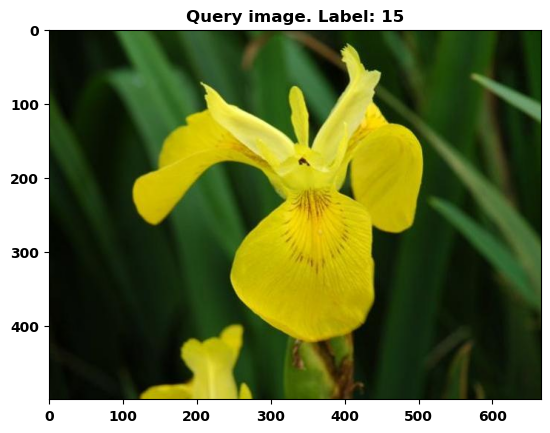

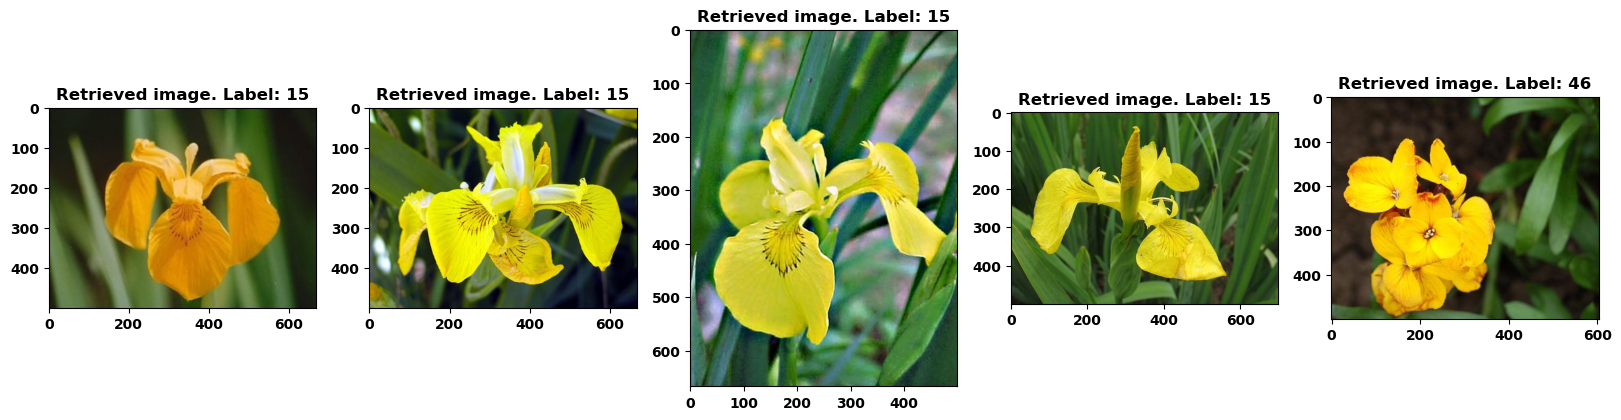

In [33]:
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(len(top_k_fisher_pca)):
    path, _ = top_k_fisher_pca[i]
    label = train_dataset.labels[train_dataset.image_paths.index(path)]
    plt.subplot(1, len(tok_k_vlad_no_pca), i + 1)
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Retrieved image. Label: {label}")

plt.show()

b) Using Model trained on full data

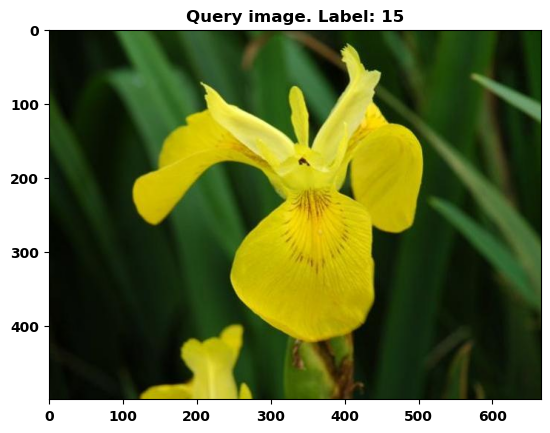

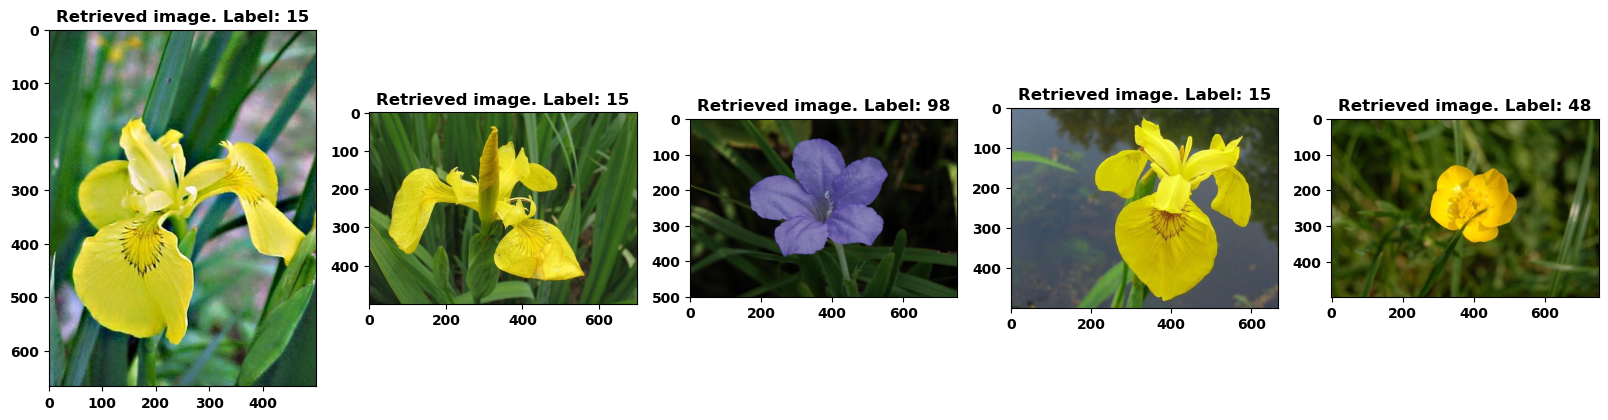

In [35]:
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(len(top_k_fisher_no_pca)):
    path, _ = top_k_fisher_no_pca[i]
    label = train_dataset.labels[train_dataset.image_paths.index(path)]
    plt.subplot(1, len(top_k_fisher_no_pca), i + 1)
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Retrieved image. Label: {label}")

plt.show()

## **7. Conclusion**

We have demonstrated:
1. Training VLAD and Fisher Vector Encoders on deep embeddings of VGG-16 Models.
2. Clustering images for different cluster sizes.
3. Comparing PCA vs. No PCA approaches.